# Practical Application III: Comparing Classifiers

**Overview**: In this practical application, the goal is to compare the performance of the following classifiers: Nearest Neighbor, Logistic Regression, Decision Trees, and Support Vector Machines. The target dataset is related to marketing bank products over the telephone.  



### Getting Started

The dataset comes from the UCI Machine Learning repository [link](https://archive.ics.uci.edu/ml/datasets/bank+marketing).  The data is from a Portugese banking institution and is a collection of the results of multiple marketing campaigns.  We will make use of the article accompanying the dataset [here](CRISP-DM-BANK.pdf) for more information on the data and features.



### Problem 1: Understanding the Data

To gain a better understanding of the data, please read the information provided in the UCI link above, and examine the **Materials and Methods** section of the paper.  How many marketing campaigns does this data represent?

A: The dataset is about 17 campaigns between May 2008 and November 2010.

### Problem 2: Read in the Data

Use pandas to read in the dataset `bank-additional-full.csv` and assign to a meaningful variable name.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import time

In [78]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures, OneHotEncoder, StandardScaler
from sklearn.metrics import mean_squared_error, accuracy_score, roc_auc_score, roc_curve, RocCurveDisplay, auc
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.compose import make_column_transformer, make_column_selector

from sklearn.dummy import DummyClassifier
from sklearn.feature_selection import chi2
from sklearn.impute import SimpleImputer

from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC

from sklearn import set_config

set_config(display="diagram")

In [3]:
full_df = pd.read_csv('data/bank-additional-full.csv', sep = ';')
full_df.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


In [4]:
full_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41188 entries, 0 to 41187
Data columns (total 21 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             41188 non-null  int64  
 1   job             41188 non-null  object 
 2   marital         41188 non-null  object 
 3   education       41188 non-null  object 
 4   default         41188 non-null  object 
 5   housing         41188 non-null  object 
 6   loan            41188 non-null  object 
 7   contact         41188 non-null  object 
 8   month           41188 non-null  object 
 9   day_of_week     41188 non-null  object 
 10  duration        41188 non-null  int64  
 11  campaign        41188 non-null  int64  
 12  pdays           41188 non-null  int64  
 13  previous        41188 non-null  int64  
 14  poutcome        41188 non-null  object 
 15  emp.var.rate    41188 non-null  float64
 16  cons.price.idx  41188 non-null  float64
 17  cons.conf.idx   41188 non-null 

### Problem 3: Understanding the Features


Examine the data description below, and determine if any of the features are missing values or need to be coerced to a different data type.


```
Input variables:
# bank client data:
1 - age (numeric)
2 - job : type of job (categorical: 'admin.','blue-collar','entrepreneur','housemaid','management','retired','self-employed','services','student','technician','unemployed','unknown')
3 - marital : marital status (categorical: 'divorced','married','single','unknown'; note: 'divorced' means divorced or widowed)
4 - education (categorical: 'basic.4y','basic.6y','basic.9y','high.school','illiterate','professional.course','university.degree','unknown')
5 - default: has credit in default? (categorical: 'no','yes','unknown')
6 - housing: has housing loan? (categorical: 'no','yes','unknown')
7 - loan: has personal loan? (categorical: 'no','yes','unknown')
# related with the last contact of the current campaign:
8 - contact: contact communication type (categorical: 'cellular','telephone')
9 - month: last contact month of year (categorical: 'jan', 'feb', 'mar', ..., 'nov', 'dec')
10 - day_of_week: last contact day of the week (categorical: 'mon','tue','wed','thu','fri')
11 - duration: last contact duration, in seconds (numeric). Important note: this attribute highly affects the output target (e.g., if duration=0 then y='no'). Yet, the duration is not known before a call is performed. Also, after the end of the call y is obviously known. Thus, this input should only be included for benchmark purposes and should be discarded if the intention is to have a realistic predictive model.
# other attributes:
12 - campaign: number of contacts performed during this campaign and for this client (numeric, includes last contact)
13 - pdays: number of days that passed by after the client was last contacted from a previous campaign (numeric; 999 means client was not previously contacted)
14 - previous: number of contacts performed before this campaign and for this client (numeric)
15 - poutcome: outcome of the previous marketing campaign (categorical: 'failure','nonexistent','success')
# social and economic context attributes
16 - emp.var.rate: employment variation rate - quarterly indicator (numeric)
17 - cons.price.idx: consumer price index - monthly indicator (numeric)
18 - cons.conf.idx: consumer confidence index - monthly indicator (numeric)
19 - euribor3m: euribor 3 month rate - daily indicator (numeric)
20 - nr.employed: number of employees - quarterly indicator (numeric)

Output variable (desired target):
21 - y - has the client subscribed a term deposit? (binary: 'yes','no')
```



In [5]:
def test_unknown_values(X, y, column):
    df_to_test = X[[column]].copy()
    df_to_test[column] = np.where(df_to_test[column] == 'unknown', 'unknown', 'known')

    crosstab = pd.crosstab(df_to_test[column], y, margins=True)
    crosstab["Ratio"] = crosstab["yes"] / crosstab["All"]

    test_transformer = make_column_transformer(
        (OneHotEncoder(sparse_output=False), [column]), verbose_feature_names_out=False
    ).fit(df_to_test)
    test_df = pd.DataFrame(
        test_transformer.transform(df_to_test),
        columns=test_transformer.get_feature_names_out(),
    )
    chi2_stats, p_values = chi2(test_df, y)
    chi2_df = pd.DataFrame(
        [chi2_stats, p_values],
        columns=test_transformer.get_feature_names_out(),
        index=["chi2", "p_value"],
    ).T

    print(f"Column: {column}")
    display(crosstab)
    display(chi2_df)

In [31]:
test_unknown_values(full_df.drop(['y'], axis=1), full_df['y'], 'housing') # imputation
test_unknown_values(full_df.drop(['y'], axis=1), full_df['y'], 'default') # remove yes
test_unknown_values(full_df.drop(['y'], axis=1), full_df['y'], 'marital') # drop
test_unknown_values(full_df.drop(['y'], axis=1), full_df['y'], 'job') # drop
test_unknown_values(full_df.drop(['y'], axis=1), full_df['y'], 'education') # imputation
test_unknown_values(full_df.drop(['y'], axis=1), full_df['y'], 'loan') # imputation

Column: housing


y,no,yes,All,Ratio
housing,,,,
known,35665,4533,40198,0.112767
unknown,883,107,990,0.108081
All,36548,4640,41188,0.112654


,chi2,p_value
housing_known,0.005101,0.943060
housing_unknown,0.207141,0.649017


Column: default


y,no,yes,All,Ratio
default,,,,
known,28394,4197,32591,0.128778
unknown,8154,443,8597,0.051530
All,36548,4640,41188,0.112654


,chi2,p_value
default_known,84.759343,3.369830e-20
default_unknown,321.320431,7.469382e-72


Column: marital


y,no,yes,All,Ratio
marital,,,,
known,36480,4628,41108,0.112581
unknown,68,12,80,0.150000
All,36548,4640,41188,0.112654


,chi2,p_value
marital_known,0.002172,0.962827
marital_unknown,1.116179,0.290743


Column: job


y,no,yes,All,Ratio
job,,,,
known,36255,4603,40858,0.112658
unknown,293,37,330,0.112121
All,36548,4640,41188,0.112654


,chi2,p_value
job_known,0.000008,0.997804
job_unknown,0.000938,0.975571


Column: education


y,no,yes,All,Ratio
education,,,,
known,35068,4389,39457,0.111235
unknown,1480,251,1731,0.145003
All,36548,4640,41188,0.112654


,chi2,p_value
education_known,0.794958,0.372605
education_unknown,18.120535,0.000021


Column: loan


y,no,yes,All,Ratio
loan,,,,
known,35665,4533,40198,0.112767
unknown,883,107,990,0.108081
All,36548,4640,41188,0.112654


,chi2,p_value
loan_known,0.005101,0.943060
loan_unknown,0.207141,0.649017


In [70]:
df = full_df.copy()

# The data description says that the 'duration' column is directly related
# to the output target 'y', so I am dropping it.
df = df.drop(["duration"], axis=1)

# Imputations: education and housing
imp_education = SimpleImputer(missing_values='unknown', strategy='most_frequent').fit_transform(df[['education']])
imp_housing = SimpleImputer(missing_values='unknown', strategy='most_frequent').fit_transform(df[['housing']])
df['education'] = [x[0] for x in imp_education]
df['housing'] = [x[0] for x in imp_housing]

# The 'default' feature has 32588 'no', 8597 'unknown', and only 3 'yes'.
# The test showed that the unknown values are related to the target column,
# so these unknown values cannot be dropped. However, I am dropping the 3 yes
# rows to avoid one additional categorical column with so few values after 
# encoding.
df = df[df.default != 'yes']

# The marital/job/loan features have unknown values but the test above showed
# that they are not related to the target column, so I am dropping these rows.
df = df[df.marital != 'unknown']
df = df[df.job != 'unknown']
df = df[df.loan != 'unknown']

# pdays is the number of days the client was last contacted since a previous
# campaign. 999 is 'never', so to better model this I am binning the values
# into four ranges: within 1 week, within 2 weeks, within 4 weeks, and never
df.pdays = pd.cut(
    df.pdays,
    bins=[-0.01, 3, 14, 30, 1000],
    labels=[
        "within_3_days",
        "within_2_weeks",
        "within_4_weeks",
        "never",
    ],
    retbins=False,
).astype("object")

# Resetting the index
df = df.reset_index(drop=True)

# Encoding housing, loan, and target yes/no values into 1/0
df.housing = df.housing.map({'yes': 1, 'no': 0})
df.loan = df.loan.map({'yes': 1, 'no': 0})
df.y = df.y.map({'yes': 1, 'no': 0})

# Sorting columns by type
df = df[df.dtypes.sort_values().index]

# Prints value_counts for all categorical features
# for i in df.select_dtypes(include="object"):
for i in df:
    print(df[i].value_counts())
    print("")

df

age
31    1894
32    1779
33    1765
36    1734
35    1701
      ... 
98       2
91       2
94       1
87       1
95       1
Name: count, Length: 78, dtype: int64

previous
0    34370
1     4411
2      722
3      207
4       66
5       18
6        5
7        1
Name: count, dtype: int64

campaign
1     17038
2     10224
3      5159
4      2563
5      1558
6       947
7       607
8       385
9       268
10      214
11      175
12      119
13       86
14       66
17       56
16       48
15       47
18       31
20       30
19       25
21       22
22       17
23       16
24       15
27       11
29       10
25        8
28        8
26        8
31        7
30        7
35        5
33        4
32        4
34        3
42        2
40        2
43        2
41        1
37        1
39        1
Name: count, dtype: int64

loan
0    33617
1     6183
Name: count, dtype: int64

housing
1    21375
0    18425
Name: count, dtype: int64

y
0    35313
1     4487
Name: count, dtype: int64

nr.employed
5228.1    

,age,previous,campaign,loan,housing,y,nr.employed,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,education,contact,month,marital,pdays,job,poutcome,default,day_of_week
0,56,0,1,0,0,0,5191.0,1.1,93.994,-36.4,4.857,basic.4y,telephone,may,married,never,housemaid,nonexistent,no,mon
1,57,0,1,0,0,0,5191.0,1.1,93.994,-36.4,4.857,high.school,telephone,may,married,never,services,nonexistent,unknown,mon
2,37,0,1,0,1,0,5191.0,1.1,93.994,-36.4,4.857,high.school,telephone,may,married,never,services,nonexistent,no,mon
3,40,0,1,0,0,0,5191.0,1.1,93.994,-36.4,4.857,basic.6y,telephone,may,married,never,admin.,nonexistent,no,mon
4,56,0,1,1,0,0,5191.0,1.1,93.994,-36.4,4.857,high.school,telephone,may,married,never,services,nonexistent,no,mon
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39795,73,0,1,0,1,1,4963.6,-1.1,94.767,-50.8,1.028,professional.course,cellular,nov,married,never,retired,nonexistent,no,fri
39796,46,0,1,0,0,0,4963.6,-1.1,94.767,-50.8,1.028,professional.course,cellular,nov,married,never,blue-collar,nonexistent,no,fri
39797,56,0,2,0,1,0,4963.6,-1.1,94.767,-50.8,1.028,university.degree,cellular,nov,married,never,retired,nonexistent,no,fri
39798,44,0,1,0,0,1,4963.6,-1.1,94.767,-50.8,1.028,professional.course,cellular,nov,married,never,technician,nonexistent,no,fri


In [ ]:
# # Checking for the total number of rows with 'unknown' values:
# rows_with_unknown_values = df[np.where(df == "unknown", True, False)]
# print(f"Rows with unknown values: {rows_with_unknown_values.shape[0]}\n")

# # Dropping all rows with 'unknown' values
# df = df.drop(index=rows_with_unknown_values.index)

### Problem 4: Understanding the Task

After examining the description and data, your goal now is to clearly state the *Business Objective* of the task.  State the objective below.

### Problem 5: Engineering Features

Now that you understand your business objective, we will build a basic model to get started.  Before we can do this, we must work to encode the data.  Using just the bank information features, prepare the features and target column for modeling with appropriate encoding and transformations.

In [71]:
df_orig_features = df.drop('y', axis = 1)
df_orig_target = df['y'].copy()

In [72]:
features_column_transformer = make_column_transformer(
    (OneHotEncoder(), make_column_selector(dtype_include=object)),
    remainder = StandardScaler(), verbose_feature_names_out=False,
).fit(df_orig_features)

In [73]:
X = pd.DataFrame(features_column_transformer.transform(df_orig_features), columns = features_column_transformer.get_feature_names_out())
y = df_orig_target.copy()

In [74]:
y.value_counts(normalize=True)

y
0    0.887261
1    0.112739
Name: proportion, dtype: float64

### Problem 6: Train/Test Split

With your data prepared, split it into a train and test set.

In [75]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)

### Problem 7: A Baseline Model

Before we build our first model, we want to establish a baseline.  What is the baseline performance that our classifier should aim to beat?

In [77]:
model_dummy = DummyClassifier(strategy='most_frequent').fit(X_train, y_train)

print(f'Baseline for training data: {model_dummy.score(X_train, y_train)}')
print(f'Baseline for testing data: {model_dummy.score(X_test, y_test)}')
print(f'ROC-AUC for train data: {roc_auc_score(y_train, model_dummy.predict(X_train))}')
print(f'ROC-AUC for train data: {roc_auc_score(y_test, model_dummy.predict(X_test))}')

Baseline for training data: 0.8872577171572147
Baseline for testing data: 0.8872696817420436
ROC-AUC for train data: 0.5
ROC-AUC for train data: 0.5


### Problem 8: A Simple Model

Use Logistic Regression to build a basic model on your data.  

In [61]:
simple_lreg = LogisticRegression(max_iter=1000).fit(X_train, y_train)

### Problem 9: Score the Model

What is the accuracy of your model?

In [62]:
print(f'Accuracy of simple Logistic Regression model')
print(f'Training data: {accuracy_score(y_train, simple_lreg.predict(X_train))}')
print(f'Training data: {accuracy_score(y_test, simple_lreg.predict(X_test))}')

Accuracy of simple Logistic Regression model
Training data: 0.9008614501076813
Training data: 0.9005025125628141


### Problem 10: Model Comparisons

Now, we aim to compare the performance of the Logistic Regression model to our KNN algorithm, Decision Tree, and SVM models.  Using the default settings for each of the models, fit and score each.  Also, be sure to compare the fit time of each of the models.  Present your findings in a `DataFrame` similar to that below:

| Model | Train Time | Train Accuracy | Test Accuracy |
| ----- | ---------- | -------------  | -----------   |
|     |    |.     |.     |

In [63]:
test_models = {
    'KNN': KNeighborsClassifier(),
    'Decision Tree': DecisionTreeClassifier(),
    'SVM': SVC(),
}

test_models_output = {}
for model_name, model in test_models.items():
    test_models_output[model_name] = {}
    
    start_time = time.time()
    test_models_output[model_name]['model'] = model.fit(X_train, y_train)
    test_models_output[model_name]['train_time'] = time.time() - start_time
    test_models_output[model_name]['train_accuracy'] = accuracy_score(y_train, test_models_output[model_name]['model'].predict(X_train))
    test_models_output[model_name]['test_accuracy'] = accuracy_score(y_test, test_models_output[model_name]['model'].predict(X_test))


In [ ]:
# ROC AUC scores

In [64]:
# KNN
print('KNN results:')
print(f'\t number_of_neighbors: {test_models["KNN"].n_neighbors}')

# Decision Tree
print('Decision Tree results:')
print(f'\t max_depth: {test_models["Decision Tree"].tree_.max_depth}')

KNN results:
	 number_of_neighbors: 5
Decision Tree results:
	 max_depth: 33


In [65]:
test_models_df = pd.DataFrame({
    'Model': list(test_models_output.keys()),
    'Train Time': [test_models_output[model_name]['train_time'] for model_name in test_models_output.keys()],
    'Train Accuracy': [test_models_output[model_name]['train_accuracy'] for model_name in test_models_output.keys()],
    'Test Accuracy': [test_models_output[model_name]['test_accuracy'] for model_name in test_models_output.keys()],
}).set_index('Model')

test_models_df

,Train Time,Train Accuracy,Test Accuracy
Model,,,
KNN,0.026325,0.911881,0.892211
Decision Tree,0.215339,0.995083,0.838107
SVM,70.853607,0.905958,0.900838


### Problem 11: Improving the Model

Now that we have some basic models on the board, we want to try to improve these.  Below, we list a few things to explore in this pursuit.

- More feature engineering and exploration.  For example, should we keep the gender feature?  Why or why not?
- Hyperparameter tuning and grid search.  All of our models have additional hyperparameters to tune and explore.  For example the number of neighbors in KNN or the maximum depth of a Decision Tree.  
- Adjust your performance metric

### Logistic Regression

In [82]:
grid_logreg = GridSearchCV(
    LogisticRegression(solver='liblinear'), 
    param_grid = {
        'penalty': ['l2', 'l1'],
        'C': 10.0**np.array([-1, 0, 1, 2, 3])
    },
    scoring='roc_auc',
    n_jobs = -1,
    # cv = [[X_train.index.values, X_test.index.values]],
    cv = 5,
    verbose = 4,
).fit(X, y)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV 3/5] END .................C=0.1, penalty=l2;, score=0.164 total time=   0.4s
[CV 4/5] END .................C=0.1, penalty=l2;, score=0.290 total time=   0.5s
[CV 2/5] END .................C=0.1, penalty=l2;, score=0.033 total time=   0.6s
[CV 1/5] END .................C=0.1, penalty=l2;, score=0.420 total time=   0.6s
[CV 5/5] END .................C=0.1, penalty=l2;, score=0.747 total time=   0.4s
[CV 3/5] END .................C=0.1, penalty=l1;, score=0.155 total time=   1.9s
[CV 4/5] END .................C=0.1, penalty=l1;, score=0.290 total time=   2.5s
[CV 1/5] END .................C=1.0, penalty=l2;, score=0.192 total time=   0.6s
[CV 1/5] END .................C=0.1, penalty=l1;, score=0.556 total time=   3.7s
[CV 2/5] END .................C=1.0, penalty=l2;, score=0.043 total time=   0.9s
[CV 3/5] END .................C=1.0, penalty=l2;, score=0.166 total time=   0.6s
[CV 5/5] END .................C=1.0, penalty=l2;

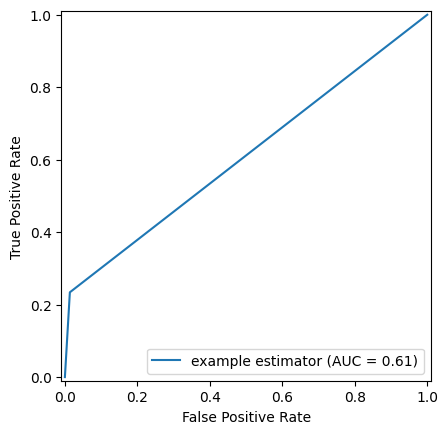

In [88]:
fpr, tpr, thresholds = roc_curve(y_test, grid_logreg.predict(X_test))
roc_auc = auc(fpr, tpr)
display = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc,
                                  estimator_name='example estimator')
display.plot()
plt.show()

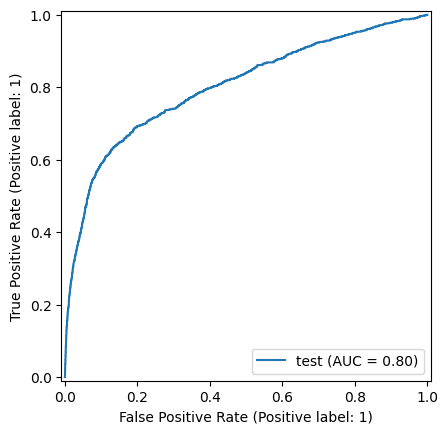

In [91]:
RocCurveDisplay.from_estimator(grid_logreg, X_test, y_test, name='test')

##### Questions